Średnia temperatura: 134.61
Odchylenie standardowe: 58.10
Min: 0.00, Max: 245.00
Anomalie stanowią: 0.40% powierzchni spoiny


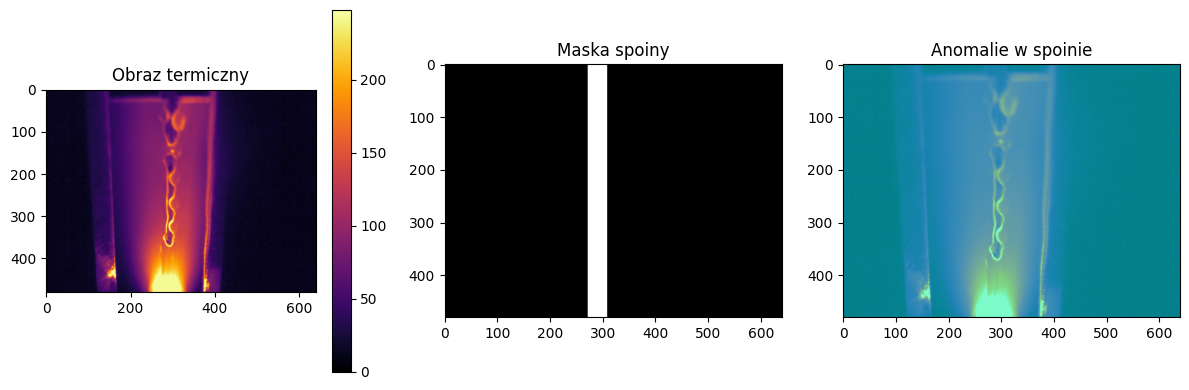

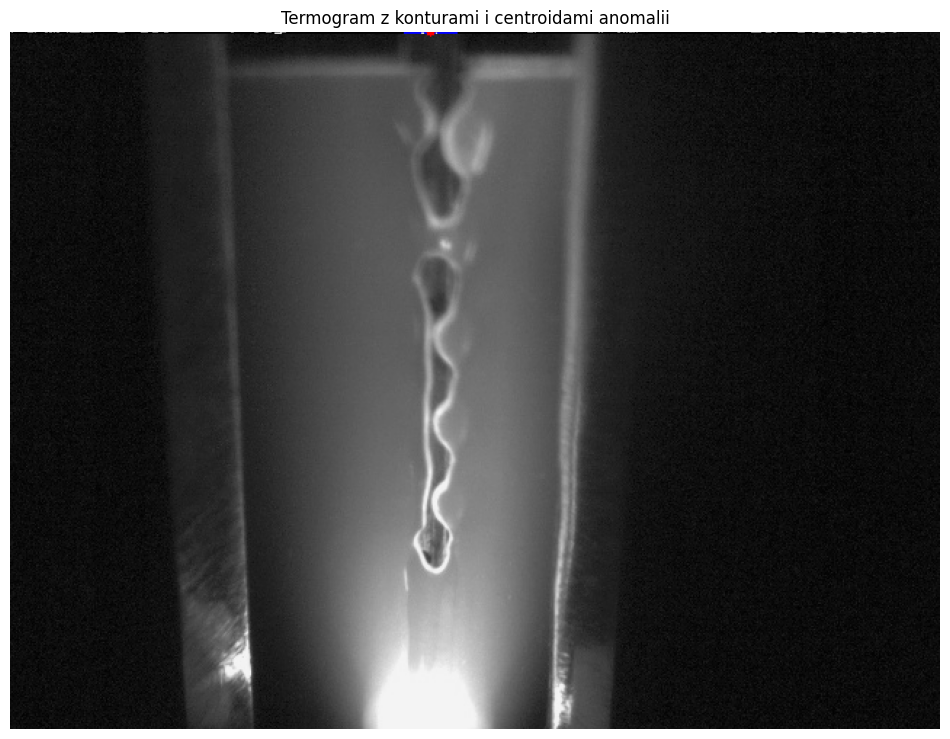

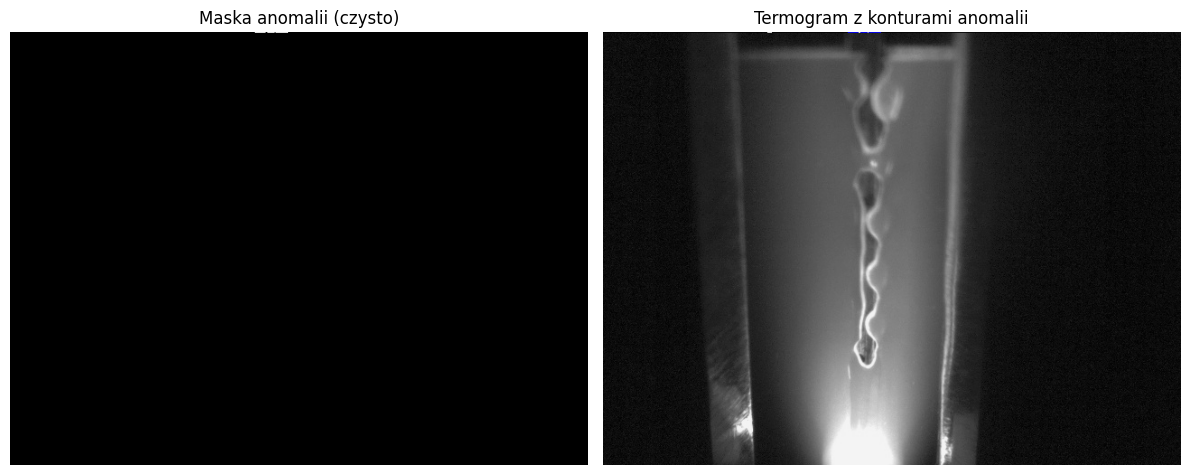

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# seq_file_name = '600_56n17_1mm_-161_09_29_59_808'
# frame = 'frame_001743'
# seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
seq_file_name = '600_51n12_1_2mm_-161_09_02_18_483'
# seq_file_name = '600_56n17_1mm_-161_09_29_59_808'
frame = 'frame_001330'
# frame = 'frame_001200'
# 1. Wczytanie obrazów
thermal_img = cv2.imread(f'frames_output/{seq_file_name}/preview_fixed/{frame}.jpg', cv2.IMREAD_UNCHANGED)
if thermal_img is None:
    raise ValueError("Nie można wczytać obrazu termicznego!")

# Konwersja do szarości, jeśli kolorowy
if len(thermal_img.shape) == 3:
    thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)

thermal_img = thermal_img.astype(np.float32)

spoiny_mask = cv2.imread(f'images/maska.png', cv2.IMREAD_GRAYSCALE)

# 2. Upewnij się, że maska ma ten sam rozmiar
if spoiny_mask.shape != thermal_img.shape:
    spoiny_mask = cv2.resize(spoiny_mask, (thermal_img.shape[1], thermal_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# 3. Zamiana na maskę binarną
_, spoiny_mask_bin = cv2.threshold(spoiny_mask, 127, 1, cv2.THRESH_BINARY)

# 4. Wyodrębnienie temperatury
spoiny_temps = thermal_img[spoiny_mask_bin == 1]
mean_temp = np.mean(spoiny_temps)
std_temp = np.std(spoiny_temps)
min_temp = np.min(spoiny_temps)
max_temp = np.max(spoiny_temps)

print(f"Średnia temperatura: {mean_temp:.2f}")
print(f"Odchylenie standardowe: {std_temp:.2f}")
print(f"Min: {min_temp:.2f}, Max: {max_temp:.2f}")

# 5. Anomalie
anomaly_mask = np.zeros_like(spoiny_mask, dtype=np.uint8)
anomaly_pixels = (thermal_img > mean_temp + 2 * std_temp) | (thermal_img < mean_temp - 2 * std_temp)
anomaly_mask[(spoiny_mask_bin == 1) & anomaly_pixels] = 255

anomaly_ratio = (np.sum(anomaly_mask == 255) / np.sum(spoiny_mask_bin == 1)) * 100
print(f"Anomalie stanowią: {anomaly_ratio:.2f}% powierzchni spoiny")


# 6. Wizualizacja
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Obraz termiczny")
plt.imshow(thermal_img, cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Maska spoiny")
plt.imshow(spoiny_mask_bin, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Anomalie w spoinie")
plt.imshow(thermal_img, cmap='inferno')
plt.imshow(anomaly_mask, cmap='cool', alpha=0.5)

plt.tight_layout()
plt.show()

# 7. Znajdź kontury anomalii
contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Konwersja termogramu do RGB dla rysowania kolorami
annotated = cv2.cvtColor(thermal_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Rysuj kontury (czerwony)
cv2.drawContours(annotated, contours, -1, (0, 0, 255), 1)

# Rysuj centroidy (niebieskie kropki)
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.circle(annotated, (cx, cy), 3, (255, 0, 0), -1)

# 8. Pokaż obraz z konturami
plt.figure(figsize=(12, 12))
plt.title("Termogram z konturami i centroidami anomalii")
plt.imshow(annotated)
plt.axis('off')
plt.show()



contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
annotated = cv2.cvtColor(thermal_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.drawContours(annotated, contours, -1, (0, 0, 255), 1)  # czerwony kolor


# Maska na czysto i termogram anomalii w subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title("Maska anomalii (czysto)")
axes[0].imshow(anomaly_mask, cmap='gray')
axes[0].axis('off')

axes[1].set_title("Termogram z konturami anomalii")
axes[1].imshow(annotated)
axes[1].axis('off')

plt.tight_layout()
plt.show()



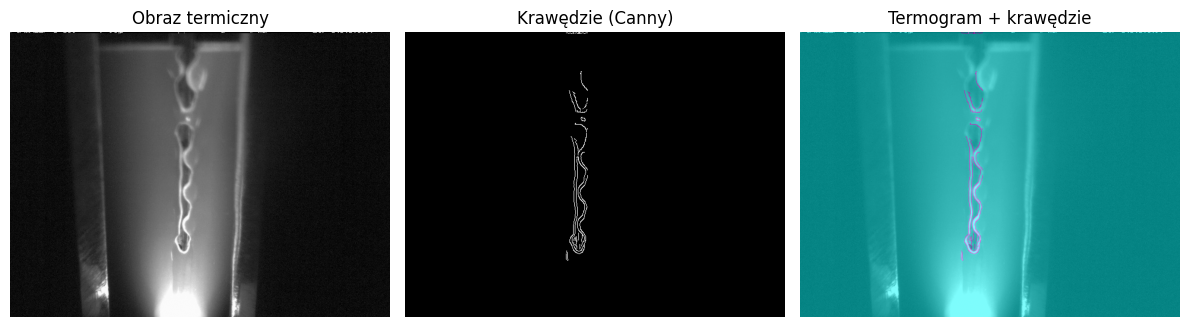

In [2]:
# === 9. Detekcja krawędzi w obrębie spoiny ===
# 1. Obraz do uint8 (Canny wymaga 8-bit)
thermal_img_uint8 = thermal_img.astype(np.uint8)

# 2. Wykrycie krawędzi metodą Canny
edges = cv2.Canny(thermal_img_uint8, threshold1=50, threshold2=150)

# 3. Ograniczenie tylko do obszaru spoiny
edges_in_spoiny = cv2.bitwise_and(edges, edges, mask=spoiny_mask_bin.astype(np.uint8))

# === 10. Wizualizacja krawędzi ===
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Obraz termiczny")
plt.imshow(thermal_img_uint8, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Krawędzie (Canny)")
plt.imshow(edges_in_spoiny, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Termogram + krawędzie")
plt.imshow(thermal_img_uint8, cmap='gray')
plt.imshow(edges_in_spoiny, cmap='cool', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
import cv2
import numpy as np
import csv
import os


seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
output_csv = 'anomaly_metrics.csv'
seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
frame = 'frame_001330'
# 1. Wczytanie obrazów
thermal_img = cv2.imread(f'frames_output/{seq_file_name}/preview_fixed/{frame}.jpg', cv2.IMREAD_UNCHANGED)
if thermal_img is None:
    raise ValueError("Nie można wczytać obrazu termicznego!")

# Konwersja do szarości, jeśli kolorowy
if len(thermal_img.shape) == 3:
    thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)

thermal_img = thermal_img.astype(np.float32)

spoiny_mask = cv2.imread(f'images/maska.png', cv2.IMREAD_GRAYSCALE)

# Dopasowanie rozmiaru
if spoiny_mask.shape != thermal_img.shape:
    spoiny_mask = cv2.resize(spoiny_mask, (thermal_img.shape[1], thermal_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Binaryzacja maski
_, spoiny_mask_bin = cv2.threshold(spoiny_mask, 127, 1, cv2.THRESH_BINARY)

# Statystyki temperatur
spoiny_temps = thermal_img[spoiny_mask_bin == 1]
mean_temp = np.mean(spoiny_temps)
std_temp = np.std(spoiny_temps)
min_temp = np.min(spoiny_temps)
max_temp = np.max(spoiny_temps)

# Wykrycie anomalii
anomaly_mask = np.zeros_like(spoiny_mask, dtype=np.uint8)
anomaly_pixels = (thermal_img > mean_temp + 2 * std_temp) | (thermal_img < mean_temp - 2 * std_temp)
anomaly_mask[(spoiny_mask_bin == 1) & anomaly_pixels] = 255

# Liczenie konturów
contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
num_anomalies = len(contours)
anomaly_ratio = (np.sum(anomaly_mask == 255) / np.sum(spoiny_mask_bin == 1)) * 100

# ✅ Zapis do CSV
write_header = not os.path.exists(output_csv)
with open(output_csv, mode='a', newline='') as file:
    writer = csv.writer(file)
    if write_header:
        writer.writerow(["frame", "num_anomalies", "anomaly_ratio_percent", "mean_temp", "std_temp", "min_temp", "max_temp"])
    writer.writerow([frame + ".jpg", num_anomalies, f"{anomaly_ratio:.2f}", f"{mean_temp:.2f}", f"{std_temp:.2f}", f"{min_temp:.2f}", f"{max_temp:.2f}"])

print(f"Zapisano dane dla {frame}: {num_anomalies} anomalii, {anomaly_ratio:.2f}% powierzchni spoiny.")


Zapisano dane dla frame_001330: 43 anomalii, 5.00% powierzchni spoiny.
